# Analysis: Home Credit Default Risk Data

Included below is an example of our predictive analysis using logistic regression, Support Vector Machines, Linear Discriminants applied to the Home Credit Default Risk Data. We aim to produce a modeling process that can successfully and accurately predict whether or not someone defaults.

We believe that one of these process can generate both accurate and meaningful predictions for Home Credit whether someone repays there loans or not.

# Setup

We use the following packages:
- `pandas` as a tool for tabular and relational data engineering
- `numpy` as a tool for vectorized mathematical operations
- `matplotlib` as a visualization tool
- `seaborn` as a statistical visualization tool

models
- `sklearn` as a versatile tool to run various statistical models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Supress, unneccesary warning for a cleaner output

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Collection

Below we read the application_train.csv from [Home Credit Deauflt Risk Data](https://www.kaggle.com/c/home-credit-default-risk/)

In [ ]:
df_application_train_initial = pd.read_csv("application_train.csv")

We looked at the columns found in the raw data, with their counts, datatypes, and what the first few rows looked like

In [ ]:
df_application_train_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Early Visuals

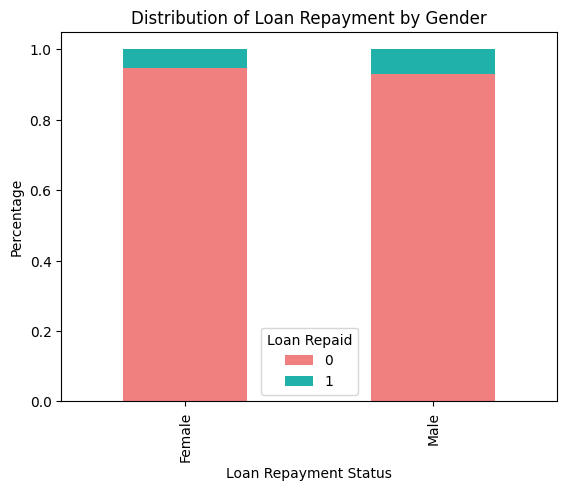

In [ ]:
df_application_train = df_application_train_initial.dropna()

value_counts_gender = df_application_train.groupby('CODE_GENDER')['TARGET'].value_counts(normalize=True)

value_counts_gender = value_counts_gender.unstack().fillna(0)

value_counts_gender.plot(kind="bar", stacked=True, color=['lightcoral', 'lightseagreen'])

labels = ['No', 'Yes']

plt.xticks(range(len(value_counts_gender.index)), ['Female' if idx == 'F' else 'Male' for idx in value_counts_gender.index])
plt.xlabel("Loan Repayment Status")
plt.ylabel("Percentage")
plt.title("Distribution of Loan Repayment by Gender")

for i, gender in enumerate(value_counts_gender.index):
    if all(col in value_counts_gender.columns for col in ['No', 'Yes']):
        for j, count in enumerate(value_counts_gender.loc[gender]):
            plt.text(i, count / 2, f'{count*100:.2f}%', ha='center', va='center')

plt.legend(title='Loan Repaid')
plt.show()


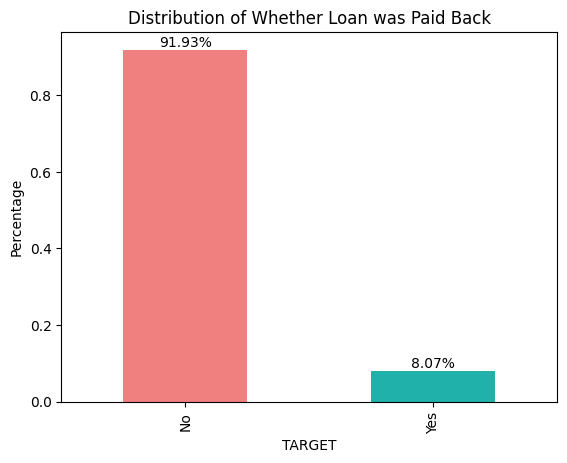

In [ ]:
value_counts = df_application_train_initial["TARGET"].value_counts(normalize=True)
value_counts.plot(kind="bar", color=['lightcoral', 'lightseagreen'])
labels = ['No' if label == 0 else 'Yes' for label in value_counts.index]
plt.xticks(range(len(labels)), labels)
plt.xlabel("TARGET")
plt.ylabel("Percentage")
plt.title("Distribution of Whether Loan was Paid Back")

for i, count in enumerate(value_counts):
    plt.text(i, count, f'{count*100:.2f}%', ha='center', va='bottom')

plt.show()



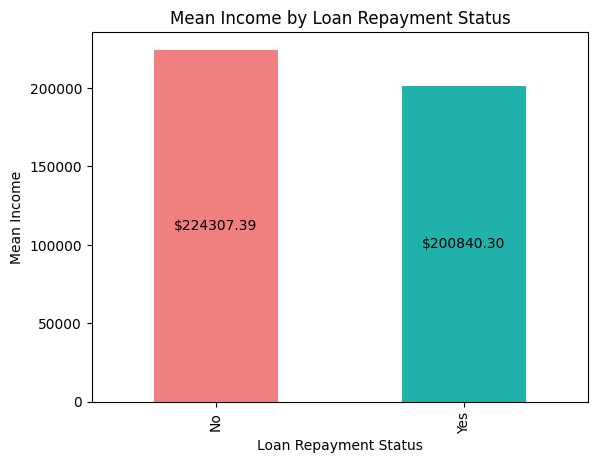

In [ ]:
df_application_train = df_application_train_initial.dropna()

mean_income_by_target = df_application_train.groupby('TARGET')['AMT_INCOME_TOTAL'].mean()

mean_income_by_target.plot(kind="bar", color=['lightcoral', 'lightseagreen'])

plt.xlabel("Loan Repayment Status")
plt.ylabel("Mean Income")
plt.title("Mean Income by Loan Repayment Status")

for i, mean_income in enumerate(mean_income_by_target):
    plt.text(i, mean_income / 2, f'${mean_income:.2f}', ha='center', va='center')

plt.xticks(range(len(mean_income_by_target.index)), ['No', 'Yes'])
plt.show()

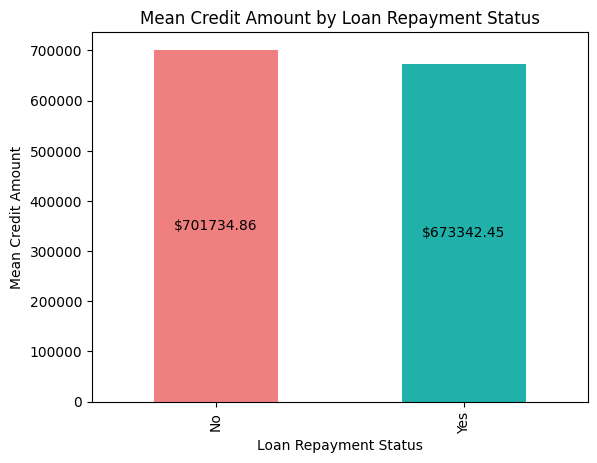

In [ ]:
df_application_train = df_application_train_initial.dropna()

mean_credit_by_target = df_application_train.groupby('TARGET')['AMT_CREDIT'].mean()

mean_credit_by_target.plot(kind="bar", color=['lightcoral', 'lightseagreen'])

plt.xlabel("Loan Repayment Status")
plt.ylabel("Mean Credit Amount")
plt.title("Mean Credit Amount by Loan Repayment Status")

for i, mean_credit in enumerate(mean_credit_by_target):
    plt.text(i, mean_credit / 2, f'${mean_credit:.2f}', ha='center', va='center')

plt.xticks(range(len(mean_credit_by_target.index)), ['No', 'Yes'])
plt.show()

## Feature Engineering

First we reduced the dataset to certain variables we wanted to look at.

In [ ]:
df_application_train = df_application_train_initial[['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
                        'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'CODE_GENDER',
                        'NAME_EDUCATION_TYPE', 'CNT_FAM_MEMBERS', 'FLAG_OWN_CAR',
                        'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE',
                        'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']]

df_application_train['DAYS_BIRTH'] = -df_application_train['DAYS_BIRTH']
df_application_train['DAYS_EMPLOYED'] = -df_application_train['DAYS_EMPLOYED']
df_application_train['DAYS_REGISTRATION'] = -df_application_train['DAYS_REGISTRATION']

We created a new variable to group the occupation type variable.

In [ ]:
df_application_train['COMMON_OCCUPATION'] = df_application_train['OCCUPATION_TYPE'].isin(['Laborers','Sales staff','Core staff','Mangers','Drivers'])


We also created a variable for the years of the clients to make the results more interpretable.

In [ ]:
df_application_train['AGE_YEARS'] = df_application_train['DAYS_BIRTH']/-365
df_application_train = df_application_train.drop("DAYS_BIRTH",axis=1)

Checking the distribution of target values:

In [ ]:
df_application_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Cleaning the Data

In [ ]:
def clean(data, stringThing = "", numThing = 0):
    for col in data.columns:
        if data[col].dtype == "object":
            data[col] = data[col].astype(str)
            data[col].fillna(stringThing, inplace=True)
        else:
            data[col].fillna(numThing, inplace=True)
    return data

In [ ]:
df = clean(df_application_train)

In [ ]:
df["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

## Functions

### Metric Functions

We built metric functions to help evaluate how powerful our predictive model is

In [ ]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [ ]:
def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp+fp) if (tp+fp) != 0 else 0

In [ ]:
def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp+fn) if (tp+fn) != 0 else 0

In [ ]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p+r) if p+r != 0 else 0

In [ ]:
def misclassification(y_true, y_pred):
    return 1-accuracy(y_true, y_pred)

In [ ]:
def roc_auc(y_true, y_pred, plot=False):
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []
    for threshold in thresholds:
        classifications = np.where(y_pred >= threshold, 1, 0)
        tp = np.sum((classifications == 1) & (y_true == 1))
        fp = np.sum((classifications == 1) & (y_true == 0))
        tn = np.sum((classifications == 0) & (y_true == 0))
        fn = np.sum((classifications == 0) & (y_true == 1))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    if plot:
        plt.plot(fpr, tpr)
    return abs(np.trapz(tpr, fpr))

In [ ]:
def specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp) if (tn + fp) != 0 else 0

In [ ]:
def fairness_gender(X_test, y_true, y_pred):
    test_data = X_test.join(y_true, how='outer')
    test_data["prediction"] = y_pred
    test_male = test_data[test_data["CODE_GENDER_M"] > 0]
    test_female = test_data[test_data["CODE_GENDER_F"] > 0]
    parity = test_female["prediction"].mean() / test_male["prediction"].mean()
    return(parity)

## Modeling Functions

We developed functions to facilitate the construction of our models, enabling us to generate predictions for our dataset.

### Model 1: Logistic Regression

Our first model of choice was Logistic Regression.

In [ ]:
class LogisticRegressionManual:

    def __init__(self, num=1000, eta=0.001):
        self.num = num
        self.eta = eta

    def fit(self, X, y):
        X = pd.get_dummies(X).astype(int)
        xCols = X.columns
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate([ones, X], axis=1)
        target = y.name
        c = y.values
        self.betas = np.zeros(X.shape[1])
        for i in range(self.num):
            zi = X @ self.betas
            p = 1 / (1 + np.exp(-zi))
            # feel free to play with the loss function. This is used because it doesn't fail
            dl = -(X.T @ (c * (1 - p))) + (X.T @ ((1-c) * p))
            if np.sum(np.sign(self.betas) != np.sign(self.betas - self.eta * dl)) > 2:
                self.eta /= 2
            self.betas = self.betas - self.eta * dl
            loss = np.sum(dl ** 2)
            if loss < 1e-4:
                break
        self.betas = pd.DataFrame(self.betas, index=["Intercept"] + xCols.tolist(), columns=["ß"])
        return self.betas

    def predict_proba(self, X_test):
        X_test = pd.get_dummies(X_test).astype(int)
        ones = np.ones((X_test.shape[0], 1))
        X_test = np.concatenate([ones, X_test], axis=1)
        zi = X_test @ self.betas
        p = 1 / (1 + np.exp(-zi))
        stuff = pd.DataFrame({"p": p["ß"], "1-p": 1-p["ß"]})
        return stuff

    def predict(self, X_test, threshold=0.5):
        probas = self.predict_proba(X_test)
        return np.where(probas["p"] >= threshold, 1, 0)

The other two models are the built-in SVC and LDA models, which we demonstrate later.

## CV Functions

We built a CV function that does Cross Validation for the data. You can pick a normal split, stratified split, or non-random split. The stratified split is done so that the training and testing splits are sampled from data with equal numbers of males and females. The non-random split is trained on some data where the people have a common occupation, and tested on data where people have a relatively uncommon occupation.

In [ ]:
def dummies(data):
    dummyCols = [col for col in data.columns if data[col].nunique() < data.shape[0]] # filter out id columns automatically
    return pd.get_dummies(data[dummyCols]).astype(int)

def splits(data, mode="random", v=5):
    data.reset_index(drop=True, inplace=True)
    data_orig = data
    data = dummies(data)
    for col in data.columns:
        if col != "TARGET":
            data[col] = (data[col] - data[col].mean()) / data[col].std()
    X = data.drop(["TARGET"], axis=1)
    y = data["TARGET"]
    sample_size = 10000
    folds = []
    if mode == "random":
        for i in range(v):
            sample_total = data.sample(sample_size, replace=False)
            trainIndex = np.random.choice(sample_total.index, size=int(len(sample_total)*0.8), replace=False)
            testIndex = sample_total.index.difference(trainIndex)
            X_train = X.iloc[X.index.isin(trainIndex)]
            X_test = X.iloc[X.index.isin(testIndex)]
            y_train = y.iloc[y.index.isin(trainIndex)]
            y_test = y.iloc[y.index.isin(testIndex)]
            folds.append((X_train, X_test, y_train, y_test))
    elif mode == "stratified":
        for i in range(v):
            strat_male = data[data_orig["CODE_GENDER"] == "M"].sample(int(sample_size*0.5), replace=False)
            strat_female = data[data_orig["CODE_GENDER"] == "F"].sample(int(sample_size*0.5), replace=False)
            strat_sample = pd.concat([strat_male, strat_female]).sample(frac=1).reset_index(drop=True)
            trainIndex = strat_sample.index[int(len(strat_sample)*0.2):]
            testIndex = strat_sample.index[:int(len(strat_sample)*0.2)]
            X_train = strat_sample.iloc[trainIndex].drop("TARGET",axis=1)
            X_test = strat_sample.iloc[testIndex].drop("TARGET",axis=1)
            y_train = strat_sample.iloc[trainIndex]['TARGET']
            y_test = strat_sample.iloc[testIndex]['TARGET']
            folds.append((X_train, X_test, y_train, y_test))
    elif mode == "non-random":
        for i in range(v):
            # group_include = data[data_orig['OCCUPATION_TYPE'].isin(['Laborers','Sales staff','Core staff','Mangers','Drivers'])]
            # group_exclude = data[data_orig['OCCUPATION_TYPE'].isin(['Laborers','Sales staff','Core staff','Mangers','Drivers']) == False]
            group_include = data[data_orig['COMMON_OCCUPATION']==True]
            group_exclude = data[data_orig['COMMON_OCCUPATION']==False]
            include_sample = group_include.sample(int(sample_size*0.8), replace=False)
            exclude_sample = group_exclude.sample(int(sample_size*0.2), replace=False)
            testIndex = exclude_sample.index
            testIndex = testIndex[testIndex < len(X)]
            trainIndex = include_sample.index
            trainIndex = trainIndex[trainIndex < len(X)]
            X_train = X.iloc[X.index.isin(trainIndex)]
            X_test = X.iloc[X.index.isin(testIndex)]
            y_train = y.iloc[y.index.isin(trainIndex)]
            y_test = y.iloc[y.index.isin(testIndex)]
            folds.append((X_train, X_test, y_train, y_test))
    else:
        raise ValueError(f"Invalid mode: {mode}")
    return folds

def cv(data, mode="random", v=5, models=[LogisticRegressionManual(), LinearDiscriminantAnalysis(solver="lsqr")]):
    folds = splits(data, mode, v)
    things = pd.DataFrame(columns=["model", "fold", "accuracy", "precision", "recall",
                                   "f1", "roc_auc", "misclassification", "fairness_gender"])
    model_num = 1
    for m in models:
        i = 1
        for X_train, X_test, y_train, y_test in folds:
            try:
                m.probability = True
            except:
                pass
            m.fit(X_train, y_train)
            probabilities = m.predict_proba(X_test)
            if model_num == 1:
                predictions = m.predict(X_test, threshold = 0.15)
            else:
                predictions = pd.Series(probabilities[:,1] >= 0.15,index=X_test.index)
            if model_num == 1:
                probabilities = pd.Series(probabilities["p"])
            else:
                probabilities = pd.Series(probabilities[:,1], index=X_test.index)
            stuff = {}
            stuff["accuracy"] = accuracy(y_test, predictions)
            stuff["precision"] = precision(y_test, predictions)
            stuff["recall"] = recall(y_test, predictions)
            stuff["specificity"] = specificity(y_test, predictions)
            stuff["f1"] = f1(y_test, predictions)
            stuff["roc_auc"] = roc_auc(y_test, probabilities)
            stuff["misclassification"] = 1 - accuracy(y_test, predictions)
            stuff["fairness_gender"] = fairness_gender(X_test, y_test, predictions)
            # stuff["fairness_age"] = fairness_age(X_test, y_test, predictions)
            if model_num == 1:
                stuff["model"] = "LogisticRegression"
            else:
                stuff["model"] = str(m)
            #stuff["fold"] = i
            i += 1
            stuff = pd.DataFrame([stuff])
            things = pd.concat([things, stuff])
        model_num += 1
    things = things.groupby(['model']).mean()
    #.drop("fold", axis=1)
    return things

In [ ]:
stuff = splits(df, mode="stratified", v=10)
X_train, X_test, y_train, y_test = stuff[0]

## Model 2: Support Vector Machine

Our second model of choice was Support Vector Machine.

In [ ]:
clf = SVC(kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Model 3: Linear Discriminant Analysis

Our third model of choice was Linear Discriminant Analysis.

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

## Running the CV to Get Model Results

Because SVC is computationally intensive, we've removed it from our cross validation function to allow for faster results. We elected not to use it in our final model due to poor results as well.

In [ ]:
cv(df, mode="stratified", v=10)

,accuracy,precision,recall,f1,roc_auc,misclassification,fairness_gender,specificity
model,,,,,,,,
LinearDiscriminantAnalysis(solver='lsqr'),0.84170,0.176749,0.213711,0.192966,0.641451,0.15830,0.178329,0.902848
LogisticRegression,0.75585,0.146158,0.276403,0.171018,0.596551,0.24415,1.039870,0.803697


## Fairness Metrics

The fairness metric we were primarily concerned with was demographic parity in terms of gender. In other words, we want a model that will predict a male will default their loan roughly as frequently as a female. Our fairness metric was best in our Logistic Regression model using a stratified sample on gender.

In [ ]:
def fairness_gender(X_test, y_true, y_pred):
    test_data = X_test.join(y_true, how='outer')
    test_data["prediction"] = y_pred
    test_male = test_data[test_data["CODE_GENDER_M"] > 0]
    test_female = test_data[test_data["CODE_GENDER_F"] > 0]
    parity = test_female["prediction"].mean() / test_male["prediction"].mean()
    return(parity)

The visual of our Fairness Metric across various thresholds

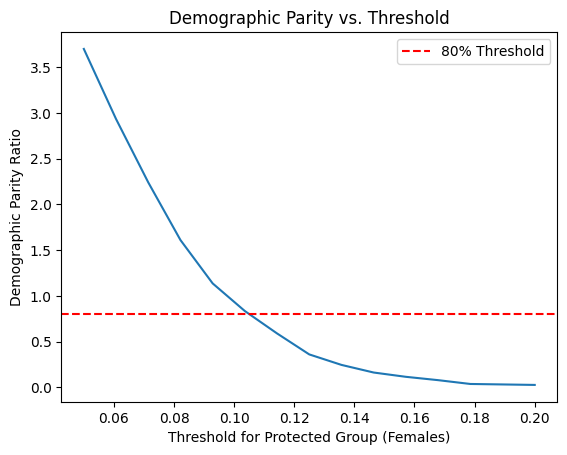

In [ ]:
stuff = splits(df, mode="stratified", v=1)
X_train, X_test, y_train, y_test = stuff[0]

lr = LogisticRegressionManual()
model = lr.fit(X_train, y_train)
df_test = X_test.join(y_test,how="outer")
df_test_reset = df_test

thresholds = np.linspace(0.05, 0.2, 15)
demographic_parity_ratios = []

for threshold in thresholds:
    df_test = df_test_reset
    df_test["pred_prob"] = lr.predict_proba(X_test)["p"]
    df_test["CODE_GENDER_F"] = np.where(df_test["CODE_GENDER_F"] > 0, 1, 0)
    df_test["predict"] = np.where(((df_test["CODE_GENDER_F"] == 1) & (df_test["pred_prob"] > threshold)) | ((df_test["CODE_GENDER_F"] == 0) & (df_test["pred_prob"] >= 0.15)), 1, 0)
    pos_rate_by_gender = df_test.groupby('CODE_GENDER_F')['predict'].mean()
    with np.errstate(divide='ignore', invalid='ignore'):
        demographic_parity_ratio = pos_rate_by_gender[1] / pos_rate_by_gender[0]

    demographic_parity_ratios.append(demographic_parity_ratio)

plt.plot(thresholds, demographic_parity_ratios)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Threshold for Protected Group (Females)')
plt.ylabel('Demographic Parity Ratio')
plt.title('Demographic Parity vs. Threshold')
plt.legend()
plt.show()

It is worth noting that it is more harmful to a protected group if they are more likely to be seen as potentially unable to pay their loan, so a lower proportion in this case is more favorable to the protected group (which is female applicants here).

## Final Model

From a preliminarly analysis, we have chosen our final model to be a Logistic Regression model, which is trained and tested on a stratified split such that males and females are equally represented. In this model, we used a probability threshold of 0.15 to classify an applicant as potentially unable to pay out the loan. Logistic Regression, in general, performed only slightly worse than Linear Discriminant Analysis in terms of accuracy, f1 score, and ROC-AUC, but because of its superior fairness score, we believe that this model is worth deploying over the better performing one due its superiority in fairness score. With it being based on a stratified sample, we can also conclude that this model will be applicable to a population that is roughly equal in males and females, which we believe to be a very plausible population, while having similar performances on those two categories.

Overall, our Logistic Regression and Linear Discriminant Analysis models were similar across the board based on performance, with LDA having a tendency to only be slightly better in each of our splitting methods. Our SVM model was by far the worst performing with our data, and with it being computationally intensive as well, we were quick to take it out of consideration.

When running our models using our non-random splits, we found that our models not only performed worse in accuracy and f1 score, but also produced very concerning fairness scores. What that told us is that our models would not have done well on people whose occupations are not very well represented in the data, because they were trained on frequently occurring occupations and tested on lesser occurring occupations.

The models using a completely random sample had similar performances to the models using a stratified sample, and this could be because gender isn't as influential as some of the other features we used. But, because the models using stratified samples were similar performing and gave us assurance that it would work similarly on future data assuming a roughly 50/50 split in gender, we chose to apply the methods using a stratified sample over a completely random split.